In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import random
import numpy as np
import cv2

In [2]:
from keras.models import Sequential, Model
from keras.layers import GRU, Dropout, Dense, Embedding, TimeDistributed, Merge, RepeatVector, Activation
from keras.callbacks import TensorBoard, ModelCheckpoint

Using TensorFlow backend.


In [3]:
print('Loading Flickr data...')

from utils import FlickrData
n_vocab = 100
max_seq_len = 16
data = FlickrData(n_vocab=n_vocab, max_seq_len=max_seq_len)
print('Done.')

Loading Flickr data...
Opening file, creating img_to_caps...
Getting word counts, creating word_to_int and int_to_word...
Creating sequences...
Creating partial padded sequences and corresponding next chars...
Done.


In [4]:
print('Loading image model (InceptionV3)... ', end='')
from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
pretrained_img_model = InceptionV3(include_top=True)
img_size = (299,299)
print('Done.')

Loading image model (InceptionV3)... Done.


In [5]:
# print('Loading language model...')

# language_model = Sequential()
# language_model.add(GRU(256, input_shape=(max_seq_len,1)))
# language_model.add(Dense(n_vocab,activation='softmax'))
# weight_fname = 'imgcap_language_weights.hdf5'
# language_model.load_weights(weight_fname)

In [6]:
print('Building language model...')

language_model = Sequential()
language_model.add(Embedding(n_vocab, 256, input_length=max_seq_len))
language_model.add(GRU(output_dim=128, return_sequences=True))
language_model.add(TimeDistributed(Dense(128)))

Building language model...


/usr/local/lib64/python3.5/site-packages/keras/engine/topology.py:368: UserWarning: The `regularizers` property of layers/models is deprecated. Regularization losses are now managed via the `losses` layer/model property.
  warnings.warn('The `regularizers` property of '


In [7]:
print('Building full model...')

# Repeat the image vector
img_input = pretrained_img_model.inputs[0]
img_output = pretrained_img_model.outputs[0]
img_output = RepeatVector(16)(img_output)
image_model = Model(input=img_input, output=img_output)

Building full model...


In [8]:
# Concatenate the two models

model = Sequential()
model.add(Merge([image_model, language_model], mode='concat', concat_axis=-1))

# Add another GRU, computes softmax over words
model.add(GRU(256, return_sequences=False))
model.add(Dense(n_vocab))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
print('Done.')

Done.


In [9]:
model_checkpoint = ModelCheckpoint('weights.{epoch:02d}-{loss:.2f}.hdf5', monitor='loss', verbose=0,
                                  save_best_only=True, mode='min')
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=False)
callbacks_list = [model_checkpoint, tensorboard]

In [10]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [11]:
def generate_caption(model, img, temperature):
    curr_seq = np.zeros([1,max_seq_len])
    for _ in range(max_seq_len):
        prediction = model.predict([img,curr_seq])
        sample_idx = int(sample(prediction[0],temperature))
        next_word = data.sorted_word_counts[sample_idx][0]
        curr_seq[0,:max_seq_len-1] = curr_seq[0,1:]
        curr_seq[0,max_seq_len-1] = sample_idx
        print(next_word, end=' ')
    print()

def show_image(img):
    b,g,r = cv2.split(img)
    curr_img = cv2.merge([r,g,b])
    curr_img = curr_img - np.min(curr_img)
    curr_img = curr_img / np.max(curr_img)
    plt.imshow(curr_img)
    plt.show()

Fitting model...
Loading weights from weights.00-1.28.hdf5
---- Current epoch 0 ----



Grabbing images...Done.
Sample image and generated caption:


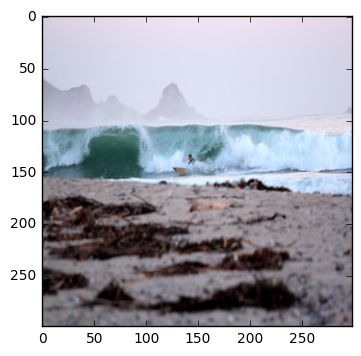

and a blue orange and white and white black is are near a person in a 
---- Current epoch 1 ----



Grabbing images...Done.
Sample image and generated caption:


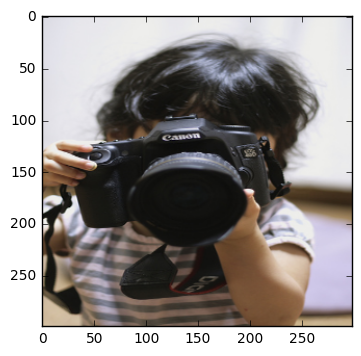

girls a small in a field in a field toy ball over a in a field 
---- Current epoch 2 ----



Grabbing images...Done.
Sample image and generated caption:


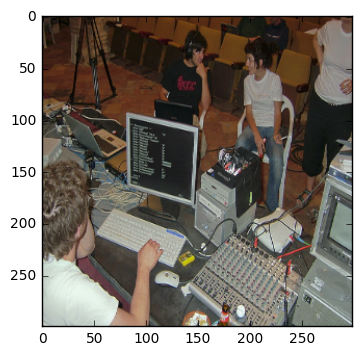

a off riding a blue as other a playing in a of a in a of 
---- Current epoch 3 ----



Grabbing images...Done.
Sample image and generated caption:


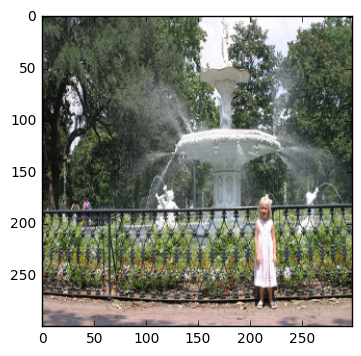

for on a beach walking on a beach walking the camera in the of a of 
---- Current epoch 4 ----



Grabbing images...Done.
Sample image and generated caption:


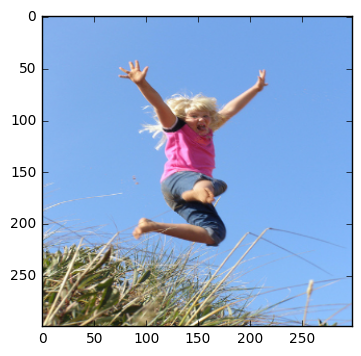

down through near the of the of the water with their woman in in snow a 
---- Current epoch 5 ----



Grabbing images...Done.
Sample image and generated caption:


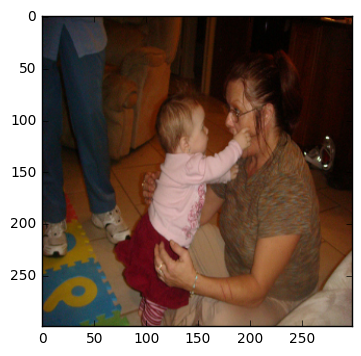

child in while a next bike on his small bike with blue sitting in the the 
---- Current epoch 6 ----



Grabbing images...Done.
Sample image and generated caption:


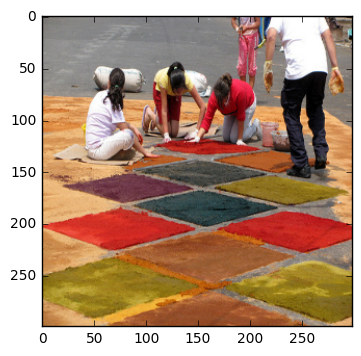

child is a while through a snow outside as a in the of a in a 
---- Current epoch 7 ----



Grabbing images...Done.
Sample image and generated caption:


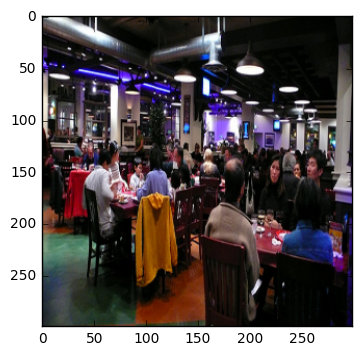

out from to a small child a in shirt riding while to the red and white 
---- Current epoch 8 ----



Grabbing images...Done.
Sample image and generated caption:


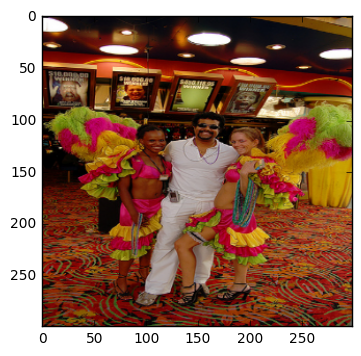

child his out from to a boy in a white shirt and a in and a 
---- Current epoch 9 ----



Grabbing images...Done.
Sample image and generated caption:


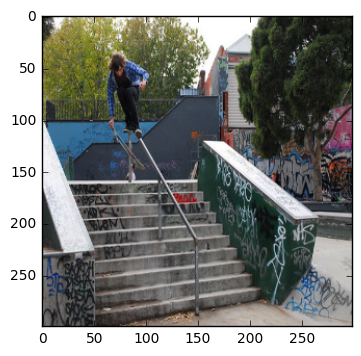

and in with a jacket up a dog next out of girls on a beach in 


In [12]:
print('Fitting model...')

nb_epochs = 10
batch_size = 8
num_img_per_epoch = 1
temperature = 1.0
do_fit, weight_fname = False, 'weights.00-1.28.hdf5'
print('Loading weights from', weight_fname)
model.load_weights(weight_fname)

for curr_epoch in range(nb_epochs):
    print('---- Current epoch', curr_epoch, '----\n\n\n')
    images = np.zeros([0,img_size[0],img_size[1],3])
    captions = np.zeros([0, max_seq_len])
    next_words = np.zeros([0,n_vocab])
    print('Grabbing images...', end='')
    for i in range(num_img_per_epoch):
        img_fname = random.choice(data.img_fnames)
        orig_img = data.get_img(img_fname)
        img = preprocess_input(orig_img)
        img = np.expand_dims(img, axis=0)
        padded_seqs, seq_end = data.img_to_padded_seqs[img_fname], data.img_to_next_chars[img_fname]
        
        n_seqs = padded_seqs.shape[0]
        img_matrix = np.repeat(img,repeats=n_seqs,axis=0)
        images = np.concatenate([images, img_matrix], axis=0)
        captions = np.concatenate([captions, padded_seqs])
        next_words = np.concatenate([next_words, seq_end])
    print('Done.')
    
    print('Sample image and generated caption:')
    show_image(orig_img)
    
    generate_caption(model, img, temperature)
    
    if do_fit:
        print('Fitting epoch...')
        model.fit([images, captions], next_words, batch_size=batch_size, nb_epoch=1, callbacks=callbacks_list, shuffle=False)
        print('Caption after fitting:\n')
        generate_caption(model, img, temperature)


In [ ]:
model.save('checkpoint_1.hdf5')